# Batch Document Extraction with InternVL3.5-8B

This notebook uses InternVL3.5-8B for document extraction on GPU hardware.

**Model**: InternVL3.5-8B (8.5B parameters: 0.3B vision + 8.2B language)

**Requirements**: 
- `transformers>=4.52.1` (critical for InternVL3.5 support)
- PyTorch with CUDA support
- Single A100/H100/H200 GPU recommended

**Key Features**:
- Cascade Reinforcement Learning (Cascade RL) for enhanced reasoning
- Visual Resolution Router (ViR) for dynamic resolution adjustment
- Improved performance over InternVL3 series

This notebook includes steps for:
* loading documents
* detecting document types  
* extracting relevant information
* generating reports

## 1. Imports

In [1]:
#Cell 1
# Path setup for V100 systems - ensures proper module resolution
import sys
import os
from pathlib import Path
os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'


# Get the notebook's directory
notebook_path = Path().absolute()
print(f"📂 Current directory: {notebook_path}")

# Ensure the project root is in the Python path
if str(notebook_path) not in sys.path:
    sys.path.insert(0, str(notebook_path))
    print(f"✅ Added {notebook_path} to sys.path")

# Verify common module can be found
try:
    import common
    print(f"✅ Common module found at: {common.__file__ if hasattr(common, '__file__') else 'built-in'}")
except ImportError as e:
    print(f"❌ Common module not found: {e}")
    print("📋 Current sys.path:")
    for p in sys.path[:5]:  # Show first 5 paths
        print(f"   - {p}")

print("✅ Path setup complete - proceed to imports")

📂 Current directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Added /home/jovyan/nfs_share/tod/LMM_POC to sys.path
✅ Common module found at: /home/jovyan/nfs_share/tod/LMM_POC/common/__init__.py
✅ Path setup complete - proceed to imports


## 2. Path Setup (V100 Compatibility)

**IMPORTANT**: If you encounter import errors on V100 systems, this cell ensures proper module resolution.

In [2]:
#Cell 2
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from rich import print as rprint
from rich.console import Console
from transformers import AutoModel, AutoTokenizer

# Project-specific imports - using absolute imports to avoid conflicts
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("✅ All imports loaded successfully")
print("✅ InternVL3 Hybrid Processor imported successfully") 
print("✅ Batch processing modules imported successfully")
print(f"📂 Working directory: {notebook_dir}")
print("🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router")
warnings.filterwarnings('ignore')

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
✅ All imports loaded successfully
✅ InternVL3 Hybrid Processor imported successfully
✅ Batch processing modules imported successfully
📂 Working directory: /home/jovyan/nfs_share/tod/LMM_POC
🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router


## 3. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [3]:
#Cell 3
# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 4. Configuration

In [4]:
#Cell 4
# Initialize console and environment configuration
console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings - InternVL3.5-8B
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3_5-8B',
    # Alternative paths:
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3_5-8B',
    # 'MODEL_PATH': 'OpenGVLab/InternVL3_5-8B',  # Auto-download from HuggingFace
    
    # Batch settings
    'DATA_DIR': f'{base_data_path}/evaluation_data',
    'GROUND_TRUTH': f'{base_data_path}/evaluation_data/ground_truth.csv',
    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: False (evaluation mode)
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # InternVL3.5 optimization settings
    'USE_QUANTIZATION': False,  # InternVL3.5-8B runs well without quantization
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 2000,
    'TORCH_DTYPE': 'bfloat16',
    'LOW_CPU_MEM_USAGE': True,
    # Flash Attention: Supported on A100/H100/H200, not on V100
    'USE_FLASH_ATTN': False  # Set to True if using modern GPUs with Flash Attention support
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Explicit file and key mapping
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# Structure:
#   'extraction_files': Maps document types to YAML prompt files
#   'extraction_keys': (Optional) Maps document types to specific keys in those files
#
# If 'extraction_keys' is not specified for a document type, the key will be
# derived from the document type name (e.g., 'INVOICE' -> 'invoice')
#
# For bank statements, structure classification (_flat or _date_grouped) is 
# automatically appended UNLESS you provide a full key in 'extraction_keys'
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': 'prompts/internvl3_prompts.yaml',
        'RECEIPT': 'prompts/internvl3_prompts.yaml', 
        'BANK_STATEMENT': 'prompts/internvl3_prompts.yaml'
    },
}

# Field list required for DocumentAwareInternVL3HybridProcessor
UNIVERSAL_FIELDS = [
    "DOCUMENT_TYPE", "BUSINESS_ABN", "SUPPLIER_NAME", "BUSINESS_ADDRESS",
    "PAYER_NAME", "PAYER_ADDRESS", "INVOICE_DATE", "STATEMENT_DATE_RANGE",
    "LINE_ITEM_DESCRIPTIONS", "LINE_ITEM_QUANTITIES", "LINE_ITEM_PRICES",
    "LINE_ITEM_TOTAL_PRICES", "IS_GST_INCLUDED", "GST_AMOUNT", "TOTAL_AMOUNT",
    "TRANSACTION_DATES", "TRANSACTION_AMOUNTS_PAID", "TRANSACTION_AMOUNTS_RECEIVED",
    "ACCOUNT_BALANCE"
]

print("✅ Configuration set up successfully")
print(f"📂 Evaluation data: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"🤖 Model: InternVL3.5-8B")
print(f"📁 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"📋 Universal fields: {len(UNIVERSAL_FIELDS)}")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print(f"⚙️  Quantization: {'ENABLED (8-bit)' if CONFIG['USE_QUANTIZATION'] else 'DISABLED (full precision)'}")
print(f"⚡ Flash Attention: {'ENABLED' if CONFIG['USE_FLASH_ATTN'] else 'DISABLED'}")
print("🚀 InternVL3.5-8B: Enhanced reasoning and dynamic resolution")

✅ Configuration set up successfully
📂 Evaluation data: /home/jovyan/nfs_share/tod/evaluation_data
📊 Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv
🤖 Model: InternVL3.5-8B
📁 Model path: /home/jovyan/nfs_share/models/InternVL3_5-8B
📁 Output base: /home/jovyan/nfs_share/tod/LMM_POC/output
📋 Universal fields: 19
🎯 Mode: Evaluation mode
⚙️  Quantization: DISABLED (full precision)
⚡ Flash Attention: DISABLED
🚀 InternVL3.5-8B: Enhanced reasoning and dynamic resolution


# 5. Output Directory Setup

In [5]:
#Cell 5
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# 6. Model Loading

**InternVL3.5-8B**: Loading the latest InternVL3.5 model with Cascade RL and Visual Resolution Router.

**Requirements**: Ensure `transformers>=4.52.1` is installed for InternVL3.5 compatibility.

In [ ]:
#Cell 6
# Load InternVL3.5 model using official pattern
# Model page: https://huggingface.co/OpenGVLab/InternVL3_5-8B
rprint("[bold green]Loading InternVL3.5-8B model...[/bold green]")
rprint("[cyan]🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)[/cyan]")
rprint("[cyan]📖 Features: Cascade RL, Visual Resolution Router (ViR)[/cyan]")

try:
    # Clear any existing CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        rprint("[blue]🧹 CUDA cache cleared[/blue]")
    
    # Load model using official InternVL3.5 pattern
    rprint("[cyan]📥 Loading model with official parameters...[/cyan]")
    model = AutoModel.from_pretrained(
        CONFIG['MODEL_PATH'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        use_flash_attn=CONFIG['USE_FLASH_ATTN'],
        trust_remote_code=True,
        device_map="auto"  # Distribute across available GPUs
    ).eval()
    
    # Load tokenizer
    rprint("[cyan]📥 Loading tokenizer...[/cyan]")
    tokenizer = AutoTokenizer.from_pretrained(
        CONFIG['MODEL_PATH'],
        trust_remote_code=True,
        use_fast=False
    )
    
    # Set generation parameters
    model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']
    
    # Display model information
    rprint("[green]✅ Model and tokenizer loaded successfully![/green]")
    
    # ============================================================================
    # BEAUTIFUL MULTI-GPU MEMORY DISPLAY (matching llama_batch.ipynb)
    # ============================================================================
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        
        if device_count > 1:
            # Multi-GPU detailed breakdown
            rprint(f"[blue]🔄 Multi-GPU Distribution Analysis ({device_count} GPUs):[/blue]")
            
            total_allocated = 0
            total_reserved = 0
            total_capacity = 0
            
            for gpu_id in range(device_count):
                gpu_allocated = torch.cuda.memory_allocated(gpu_id) / 1e9
                gpu_reserved = torch.cuda.memory_reserved(gpu_id) / 1e9
                gpu_capacity = torch.cuda.get_device_properties(gpu_id).total_memory / 1e9
                gpu_name = torch.cuda.get_device_name(gpu_id)
                
                total_allocated += gpu_allocated
                total_reserved += gpu_reserved
                total_capacity += gpu_capacity
                
                usage_pct = (gpu_allocated / gpu_capacity) * 100 if gpu_capacity > 0 else 0
                rprint(f"   GPU {gpu_id} ({gpu_name}): {gpu_allocated:.1f}GB/{gpu_capacity:.0f}GB ({usage_pct:.1f}%)")
            
            rprint(f"[blue]📊 Total across all GPUs: {total_allocated:.1f}GB allocated, {total_reserved:.1f}GB reserved, {total_capacity:.0f}GB capacity[/blue]")
            
            if hasattr(model, 'hf_device_map'):
                from collections import Counter
                device_distribution = Counter(model.hf_device_map.values())
                rprint(f"[green]✅ Model successfully distributed: {dict(device_distribution)}[/green]")
        else:
            # Single GPU
            allocated = torch.cuda.memory_allocated() / 1e9
            reserved = torch.cuda.memory_reserved() / 1e9
            total = torch.cuda.get_device_properties(0).total_memory / 1e9
            gpu_name = torch.cuda.get_device_name(0)
            usage_pct = (allocated / total) * 100 if total > 0 else 0
            
            rprint(f"[blue]📊 GPU {gpu_name}: {allocated:.1f}GB/{total:.0f}GB ({usage_pct:.1f}%)[/blue]")
    
    # ============================================================================
    # BEAUTIFUL CONFIGURATION TABLE (matching llama_batch.ipynb)
    # ============================================================================
    from rich.table import Table
    
    config_table = Table(title="🔧 InternVL3.5-8B Model Configuration")
    config_table.add_column("Setting", style="cyan")
    config_table.add_column("Value", style="yellow")
    config_table.add_column("Status", style="green")
    
    # Model path
    model_name = Path(CONFIG['MODEL_PATH']).name
    config_table.add_row("Model Path", model_name, "✅ Valid")
    
    # Model type
    config_table.add_row("Model Type", "InternVL3.5-8B", "✅ Cascade RL + ViR")
    
    # Device placement
    config_table.add_row("Device Placement", str(next(model.parameters()).device), "✅ Loaded")
    
    # Quantization
    quant_status = "✅ 16-bit (Performance Optimized)" if not CONFIG['USE_QUANTIZATION'] else "✅ 8-bit (Memory Optimized)"
    quant_method = "16-bit" if not CONFIG['USE_QUANTIZATION'] else "8-bit"
    config_table.add_row("Quantization Method", quant_method, quant_status)
    
    # Data type
    config_table.add_row("Data Type", str(CONFIG['TORCH_DTYPE']), "✅ Recommended")
    
    # Max new tokens
    config_table.add_row("Max New Tokens", str(CONFIG['MAX_NEW_TOKENS']), "✅ Generation Ready")
    
    # GPU configuration
    if torch.cuda.is_available():
        if device_count > 1:
            gpu_info = f"{device_count}x {torch.cuda.get_device_name(0)} ({total_capacity:.0f}GB)"
            gpu_status = f"✅ {total_capacity:.0f}GB Total"
        else:
            gpu_info = f"{torch.cuda.get_device_name(0)} ({total:.0f}GB)"
            gpu_status = "✅ Single GPU"
    else:
        gpu_info = "CPU"
        gpu_status = "💻 CPU Mode"
    config_table.add_row("GPU Configuration", gpu_info, gpu_status)
    
    # Model parameters
    param_count = sum(p.numel() for p in model.parameters())
    config_table.add_row("Model Parameters", f"{param_count:,}", "✅ Loaded")
    
    # Flash Attention
    flash_attn_status = "✅ Enabled" if CONFIG['USE_FLASH_ATTN'] else "⚠️ Disabled"
    config_table.add_row("Flash Attention", str(CONFIG['USE_FLASH_ATTN']), flash_attn_status)
    
    console.print(config_table)
    
    # Initialize the hybrid processor with loaded model components
    rprint("[cyan]🔧 Initializing document-aware processor...[/cyan]")
    hybrid_processor = DocumentAwareInternVL3HybridProcessor(
        field_list=UNIVERSAL_FIELDS,
        model_path=CONFIG['MODEL_PATH'],
        debug=CONFIG['VERBOSE'],
        pre_loaded_model=model,
        pre_loaded_tokenizer=tokenizer,
        prompt_config=PROMPT_CONFIG
    )
    
    rprint("[bold green]✅ InternVL3.5-8B ready for document-aware processing[/bold green]")
    rprint("[cyan]🎯 Enhanced with Cascade RL for improved reasoning[/cyan]")
    
except Exception as e:
    rprint(f"[red]❌ Error loading model: {e}[/red]")
    rprint("[yellow]💡 Ensure transformers>=4.52.1 is installed[/yellow]")
    rprint("[yellow]💡 Check model path is correct[/yellow]")
    raise

# 7. Image Discovery

In [7]:
#Cell 7
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod/evaluation_data

Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv

Mode: Evaluation mode

  1. image_001.png
  2. image_002.png
  3. image_003.png
  4. image_004.png
  5. image_005.png
  ... and 4 more


## 8. Batch Processing

In [8]:
#Cell 8
# Initialize batch processor with proven infrastructure (same pattern as llama_batch.ipynb)
processor = BatchDocumentProcessor(
    model=hybrid_processor,  # InternVL3 hybrid processor (handler)
    processor=None,          # Not needed for InternVL3
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Loaded ground truth for 9 images

📋 Sample GT keys: ['image_001.png', 'image_002.png', 'image_004.png']

🚀 Starting Batch Processing

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Output()

Processing [1/9]: image_001.png

🔍 TRACE: Processing InternVL3 image 1/9: image_001.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

✅ Detected Document Type: RECEIPT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'RECEIPT', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (538 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 06 082 698 025
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000
PAYER_NAME: Robert Taylor
PAYER_ADDRESS: 243 Adelaide Street, Perth WA 6000
INVOICE_DATE: 05/08/2025
LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel
LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3
LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.70
LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10
IS_GST_INCLUDED: Yes
GST_AMOUNT: $8.62
TOTAL_AMOUNT: $94.87

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '06 082 698 025' -> '06082698025'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '481 Bourke Street  Perth WA 6000' -> 🏠 Address cleaned: '481 Bourke Street  
Perth WA 6000' -> '481 Bourke Street Perth WA 6000'

'481 Bourke Street Perth WA 6000'

🧹 CLEANER CALLED: PAYER_NAME: 'Robert Taylor' -> 'Robert Taylor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '243 Adelaide Street  Perth WA 6000' -> 🏠 Address cleaned: '243 Adelaide Street 
Perth WA 6000' -> '243 Adelaide Street Perth WA 6000'

'243 Adelaide Street Perth WA 6000'

🧹 CLEANER CALLED: INVOICE_DATE: '05/08/2025' -> '05/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel' -> 'Car 
Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 1 | 1 | 2 | 3' -> '3 | 1 | 1 | 2 | 3'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$15.00 | $4.50 | $1.65 | $15.00 | $1.70' -> '$15.00 | $4.50 | $1.65 | $15.00 
| $1.70'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$45.00 | $4.50 | $1.65 | $30.00 | $5.10' -> '$45.00 | $4.50 | $1.65 | 
$30.00 | $5.10'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$8.62' -> '$8.62'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$94.87' -> '$94.87'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "06082698025"

✅ SUPPLIER_NAME: "Liberty Oil"

✅ BUSINESS_ADDRESS: "481 Bourke Street Perth WA 6000"

✅ PAYER_NAME: "Robert Taylor"

✅ PAYER_ADDRESS: "243 Adelaide Street Perth WA 6000"

✅ INVOICE_DATE: "05/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel"

✅ LINE_ITEM_QUANTITIES: "3 | 1 | 1 | 2 | 3"

✅ LINE_ITEM_PRICES: "$15.00 | $4.50 | $1.65 | $15.00 | $1.70"

✅ LINE_ITEM_TOTAL_PRICES: "$45.00 | $4.50 | $1.65 | $30.00 | $5.10"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$8.62"

✅ TOTAL_AMOUNT: "$94.87"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.51GB allocated, 7.53GB reserved

✅ Final GPU memory: 7.51GB allocated, 7.53GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_001.png, doc_type=RECEIPT

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_001.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [2/9]: image_002.png

🔍 TRACE: Processing InternVL3 image 2/9: image_002.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: This is a RECEIPT.

🔍 PARSING DEBUG - Raw response: 'This is a RECEIPT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a receipt.'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

✅ Detected Document Type: RECEIPT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: This is a RECEIPT.

🔍 PARSING DEBUG - Raw response: 'This is a RECEIPT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a receipt.'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'This is a RECEIPT.',
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (595 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 29 466 483 258
SUPPLIER_NAME: Ampol Limited
BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800
PAYER_NAME: Sophie Martin
PAYER_ADDRESS: 467 Collins Street, Hobart TAS 7000
INVOICE_DATE: 18/07/2025
LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded
LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2
LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75
LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50
IS_GST_INCLUDED: Yes
GST_AMOUNT: $5.20
TOTAL_AMOUNT: $57.15

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '29 466 483 258' -> '29466483258'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Ampol Limited' -> 'Ampol Limited'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '680 Collins Street  Darwin NT 0800' -> 🏠 Address cleaned: '680 Collins 
Street  Darwin NT 0800' -> '680 Collins Street Darwin NT 0800'

'680 Collins Street Darwin NT 0800'

🧹 CLEANER CALLED: PAYER_NAME: 'Sophie Martin' -> 'Sophie Martin'

🧹 CLEANER CALLED: PAYER_ADDRESS: '467 Collins Street  Hobart TAS 7000' -> 🏠 Address cleaned: '467 Collins Street 
Hobart TAS 7000' -> '467 Collins Street Hobart TAS 7000'

'467 Collins Street Hobart TAS 7000'

🧹 CLEANER CALLED: INVOICE_DATE: '18/07/2025' -> '18/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car
Wash | Premium Unleaded' -> 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium
Unleaded'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 1 | 2 | 2 | 2 | 2' -> '1 | 1 | 2 | 2 | 2 | 2'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75' -> '$4.20 | $1.75 | $4.50 | 
$1.75 | $15.00 | $1.75'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50' -> '$4.20 | $1.75 | 
$9.00 | $3.50 | $30.00 | $3.50'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$5.20' -> '$5.20'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$57.15' -> '$57.15'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "29466483258"

✅ SUPPLIER_NAME: "Ampol Limited"

✅ BUSINESS_ADDRESS: "680 Collins Street Darwin NT 0800"

✅ PAYER_NAME: "Sophie Martin"

✅ PAYER_ADDRESS: "467 Collins Street Hobart TAS 7000"

✅ INVOICE_DATE: "18/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | 
Premium Unleaded"

✅ LINE_ITEM_QUANTITIES: "1 | 1 | 2 | 2 | 2 | 2"

✅ LINE_ITEM_PRICES: "$4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75"

✅ LINE_ITEM_TOTAL_PRICES: "$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$5.20"

✅ TOTAL_AMOUNT: "$57.15"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.51GB allocated, 7.53GB reserved

✅ Final GPU memory: 7.51GB allocated, 7.53GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_002.png, doc_type=RECEIPT

✓ Extracted 14 fields from image_002.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_002.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [3/9]: image_003.png

🔍 TRACE: Processing InternVL3 image 3/9: image_003.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_003.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏗️ Bank statement structure: flat

📝 Using prompt key: bank_statement_flat

📝 Using bank_statement_flat prompt (prompt_config): 1935 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_003.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏗️ Bank statement structure: flat

📝 Using prompt key: bank_statement_flat

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_flat'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_flat'

📝 Loading bank_statement_flat prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_flat'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (1935 chars):

================================================================================

Extract structured data from this flat table bank statement for taxpayer expense claims.

STEP 1 - LOCATE TRANSACTION TABLE:
Focus on the main transaction table (usually center/body area).
Columns: Date | Description | Debit/Withdrawal | Credit/Deposit | Balance
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
TARGET COLUMNS: Date + Description + Debit/Withdrawal amount

For each row check:
- Has value in DEBIT/WITHDRAWAL column? → Extract this row
- Has value in CREDIT/DEPOSIT column only? → SKIP this row
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received

STEP 3 - EXTRACT ROW-BY-ROW:
For EACH debit row:
1. Extract DATE (DD/MM/YYYY format)
2. Extract DESCRIPTION (exact text)
3. Extract AMOUNT (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries
- Process chronologically (top to bottom)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any row with value in CREDIT/DEPOSIT column
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Date range like "01/01/2025 to 31/01/2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing fields

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (438 chars):

================================================================================

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 03/05/2025 to 10/05/2025
LINE_ITEM_DESCRIPTIONS: ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | ATM 
WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | ATM WITHDRAWAL ANZ ATM
TRANSACTION_DATES: 03/05/2025 | 04/05/2025 | 05/05/2025 | 07/05/2025 | 08/05/2025 | 10/05/2025
TRANSACTION_AMOUNTS_PAID: $288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '03/05/2025 to 10/05/2025' -> '03/05/2025 to 10/05/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE
COLES EXP | ATM WITHDRAWAL A...' -> 'ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES 
EXP | ATM WITHDRAWAL A...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '03/05/2025 | 04/05/2025 | 05/05/2025 | 07/05/2025 | 08/05/2025 | 10/05/2025'
-> '03/05/2025 | 04/05/2025 | 05/05/2025 | 07/05/2025 | 08/05/2025 | 10/05/2025'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72' -> '$288.03
| $22.50 | $114.66 | $187.59 | $112.50 | $146.72'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "03/05/2025 to 10/05/2025"

✅ LINE_ITEM_DESCRIPTIONS: "ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | 
ATM WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | ATM WITHDRAWAL ANZ ATM"

✅ TRANSACTION_DATES: "03/05/2025 | 04/05/2025 | 05/05/2025 | 07/05/2025 | 08/05/2025 | 10/05/2025"

✅ TRANSACTION_AMOUNTS_PAID: "$288.03 | $22.50 | $114.66 | $187.59 | $112.50 | $146.72"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.52GB allocated, 7.54GB reserved

✅ Final GPU memory: 7.52GB allocated, 7.54GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_003.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from image_003.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 100.0% for image_003.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [4/9]: image_004.png

🔍 TRACE: Processing InternVL3 image 4/9: image_004.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

✅ Detected Document Type: RECEIPT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'RECEIPT', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (474 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 66 658 925 499
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 993 Pitt Street, Darwin NT 0800
PAYER_NAME: William Harris
PAYER_ADDRESS: 52 Bourke Street, Darwin NT 0800
INVOICE_DATE: 19/07/2025
LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol
LINE_ITEM_QUANTITIES: 1 | 2 | 3
LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65
LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95
IS_GST_INCLUDED: Yes
GST_AMOUNT: $1.01
TOTAL_AMOUNT: $11.11

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '66 658 925 499' -> '66658925499'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '993 Pitt Street  Darwin NT 0800' -> 🏠 Address cleaned: '993 Pitt Street  
Darwin NT 0800' -> '993 Pitt Street Darwin NT 0800'

'993 Pitt Street Darwin NT 0800'

🧹 CLEANER CALLED: PAYER_NAME: 'William Harris' -> 'William Harris'

🧹 CLEANER CALLED: PAYER_ADDRESS: '52 Bourke Street  Darwin NT 0800' -> 🏠 Address cleaned: '52 Bourke Street  
Darwin NT 0800' -> '52 Bourke Street Darwin NT 0800'

'52 Bourke Street Darwin NT 0800'

🧹 CLEANER CALLED: INVOICE_DATE: '19/07/2025' -> '19/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Premium Unleaded | Diesel | Unleaded Petrol' -> 'Premium Unleaded | 
Diesel | Unleaded Petrol'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 2 | 3' -> '1 | 2 | 3'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$1.75 | $1.70 | $1.65' -> '$1.75 | $1.70 | $1.65'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1.75 | $3.40 | $4.95' -> '$1.75 | $3.40 | $4.95'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$1.01' -> '$1.01'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$11.11' -> '$11.11'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "66658925499"

✅ SUPPLIER_NAME: "Liberty Oil"

✅ BUSINESS_ADDRESS: "993 Pitt Street Darwin NT 0800"

✅ PAYER_NAME: "William Harris"

✅ PAYER_ADDRESS: "52 Bourke Street Darwin NT 0800"

✅ INVOICE_DATE: "19/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Premium Unleaded | Diesel | Unleaded Petrol"

✅ LINE_ITEM_QUANTITIES: "1 | 2 | 3"

✅ LINE_ITEM_PRICES: "$1.75 | $1.70 | $1.65"

✅ LINE_ITEM_TOTAL_PRICES: "$1.75 | $3.40 | $4.95"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$1.01"

✅ TOTAL_AMOUNT: "$11.11"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.51GB allocated, 7.53GB reserved

✅ Final GPU memory: 7.51GB allocated, 7.53GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_004.png, doc_type=RECEIPT

✓ Extracted 14 fields from image_004.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_004.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [5/9]: image_005.png

🔍 TRACE: Processing InternVL3 image 5/9: image_005.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'INVOICE', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (610 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 73 154 562 747
SUPPLIER_NAME: Aussie Office Supplies Pty Ltd
BUSINESS_ADDRESS: 123 Collins Street, Melbourne VIC 3000
PAYER_NAME: Perth Building Materials
PAYER_ADDRESS: 456 George Street, Sydney NSW 2000
INVOICE_DATE: 06/08/2025
LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand
LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1
LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24
LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24
IS_GST_INCLUDED: Yes
GST_AMOUNT: $439.46
TOTAL_AMOUNT: $4834.03

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '73 154 562 747' -> '73154562747'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Aussie Office Supplies Pty Ltd' -> 'Aussie Office Supplies Pty Ltd'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '123 Collins Street  Melbourne VIC 3000' -> 🏠 Address cleaned: '123 Collins 
Street  Melbourne VIC 3000' -> '123 Collins Street Melbourne VIC 3000'

'123 Collins Street Melbourne VIC 3000'

🧹 CLEANER CALLED: PAYER_NAME: 'Perth Building Materials' -> 'Perth Building Materials'

🧹 CLEANER CALLED: PAYER_ADDRESS: '456 George Street  Sydney NSW 2000' -> 🏠 Address cleaned: '456 George Street  
Sydney NSW 2000' -> '456 George Street Sydney NSW 2000'

'456 George Street Sydney NSW 2000'

🧹 CLEANER CALLED: INVOICE_DATE: '06/08/2025' -> '06/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor 
Stand' -> 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 3 | 2 | 3 | 1' -> '3 | 3 | 2 | 3 | 1'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$490.12 | $38.84 | $431.58 | $138.58 | $1968.24' -> '$490.12 | $38.84 | 
$431.58 | $138.58 | $1968.24'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24' -> '$1470.35 | 
$116.53 | $863.17 | $415.74 | $1968.24'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$439.46' -> '$439.46'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$4834.03' -> '$4834.03'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "73154562747"

✅ SUPPLIER_NAME: "Aussie Office Supplies Pty Ltd"

✅ BUSINESS_ADDRESS: "123 Collins Street Melbourne VIC 3000"

✅ PAYER_NAME: "Perth Building Materials"

✅ PAYER_ADDRESS: "456 George Street Sydney NSW 2000"

✅ INVOICE_DATE: "06/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand"

✅ LINE_ITEM_QUANTITIES: "3 | 3 | 2 | 3 | 1"

✅ LINE_ITEM_PRICES: "$490.12 | $38.84 | $431.58 | $138.58 | $1968.24"

✅ LINE_ITEM_TOTAL_PRICES: "$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$439.46"

✅ TOTAL_AMOUNT: "$4834.03"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.52GB allocated, 7.54GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_005.png, doc_type=INVOICE

✓ Extracted 14 fields from image_005.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_005.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

[5/9] image_005.png: INVOICE - Accuracy: 92.9% - Time: 11.70s

Processing [6/9]: image_006.png

🔍 TRACE: Processing InternVL3 image 6/9: image_006.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'INVOICE', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([10, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (687 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 26 668 321 195
SUPPLIER_NAME: Maritime Mechanics
BUSINESS_ADDRESS: 1/92 Watt Road, Mornington, VIC 3931
PAYER_NAME: Tod Nestor
PAYER_ADDRESS: 29 Frederick Street, FernTree Gully VIC 3156
INVOICE_DATE: 27/08/2025
LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete |
Freight - Parts In
LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0
LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00
LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00
IS_GST_INCLUDED: Yes
GST_AMOUNT: $374.98
TOTAL_AMOUNT: $4,124.82

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '26 668 321 195' -> '26668321195'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Maritime Mechanics' -> 'Maritime Mechanics'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '1/92 Watt Road  Mornington  VIC 3931' -> 🏠 Address cleaned: '1/92 Watt Road 
Mornington  VIC 3931' -> '1/92 Watt Road Mornington VIC 3931'

'1/92 Watt Road Mornington VIC 3931'

🧹 CLEANER CALLED: PAYER_NAME: 'Tod Nestor' -> 'Tod Nestor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street  FernTree Gully VIC 3156' -> 🏠 Address cleaned: '29 
Frederick Street  FernTree Gully VIC 3156' -> '29 Frederick Street FernTree Gully VIC 3156'

'29 Frederick Street FernTree Gully VIC 3156'

🧹 CLEANER CALLED: INVOICE_DATE: '27/08/2025' -> '27/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | 
Labour - To Complete | Freight ...' -> 'VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour
- To Complete | Freight ...'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0' -> '1.0 | 2.0 | 1.0 | 1.0 | 5.5 
| 8.5 | 1.0'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00' -> 
'$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00' 
-> '$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$374.98' -> '$374.98'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$4,124.82' -> '$4124.82'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "26668321195"

✅ SUPPLIER_NAME: "Maritime Mechanics"

✅ BUSINESS_ADDRESS: "1/92 Watt Road Mornington VIC 3931"

✅ PAYER_NAME: "Tod Nestor"

✅ PAYER_ADDRESS: "29 Frederick Street FernTree Gully VIC 3156"

✅ INVOICE_DATE: "27/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To 
Complete | Freight - Parts In"

✅ LINE_ITEM_QUANTITIES: "1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0"

✅ LINE_ITEM_PRICES: "$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00"

✅ LINE_ITEM_TOTAL_PRICES: "$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$374.98"

✅ TOTAL_AMOUNT: "$4124.82"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.52GB allocated, 7.53GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_006.png, doc_type=INVOICE

✓ Extracted 14 fields from image_006.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_006.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [7/9]: image_007.png

🔍 TRACE: Processing InternVL3 image 7/9: image_007.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: This is an **INVOICE**.

🔍 PARSING DEBUG - Raw response: 'This is an **INVOICE**.'

🔍 PARSING DEBUG - Cleaned response: 'this is an **invoice**.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: This is an **INVOICE**.

🔍 PARSING DEBUG - Raw response: 'This is an **INVOICE**.'

🔍 PARSING DEBUG - Cleaned response: 'this is an **invoice**.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'This is an 
**INVOICE**.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (563 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 64 086 174 781
SUPPLIER_NAME: Telstra Limited
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: Mr Maurice Nestor
PAYER_ADDRESS: 29 Frederick Street FERN TREE GULLY VIC 3156
INVOICE_DATE: 16/Jul/2025
LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 0409 
760 513 | Mobile data service 0428 992 418
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: Yes
GST_AMOUNT: $10.91
TOTAL_AMOUNT: $120.00

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '64 086 174 781' -> '64086174781'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Telstra Limited' -> 'Telstra Limited'

🧹 CLEANER CALLED: PAYER_NAME: 'Mr Maurice Nestor' -> 'Mr Maurice Nestor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street FERN TREE GULLY VIC 3156' -> '29 Frederick Street FERN TREE 
GULLY VIC 3156'

🧹 CLEANER CALLED: INVOICE_DATE: '16/07/2025' -> '16/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile
data service 0409 760 513 | ...' -> 'Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data 
service 0409 760 513 | ...'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$45.00 | $30.00 | $25.00 | $20.00' -> '$45.00 | $30.00 | $25.00 | $20.00'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$10.91' -> '$10.91'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$120.00' -> '$120.00'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "64086174781"

✅ SUPPLIER_NAME: "Telstra Limited"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

✅ PAYER_NAME: "Mr Maurice Nestor"

✅ PAYER_ADDRESS: "29 Frederick Street FERN TREE GULLY VIC 3156"

✅ INVOICE_DATE: "16/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 
0409 760 513 | Mobile data service 0428 992 418"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

✅ LINE_ITEM_PRICES: "$45.00 | $30.00 | $25.00 | $20.00"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$10.91"

✅ TOTAL_AMOUNT: "$120.00"

================================================================================

✅ Extracted 11/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.51GB allocated, 7.53GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 11/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_007.png, doc_type=INVOICE

✓ Extracted 11 fields from image_007.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 71.3% for image_007.png

  Precision: 71.3% | Recall: 71.3%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [8/9]: image_008.png

🔍 TRACE: Processing InternVL3 image 8/9: image_008.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_008.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_008.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (2000 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 08/08/2025 TO 07/09/2025
LINE_ITEM_DESCRIPTIONS: EFTPOS Cash Out | PriceLine Pharmacy Mackay QLD | EFTPOS Purchase OfficeWorks | Mortgage 
Payment | OSKO Payment to Mike Chen | Direct Debit | Salary Payment | DD Insurance Acme Corp Pty Ltd | Auto Payment
Utilities AGL | Direct Credit Salary | BPAY Payment Bill | Professional Services Red Energy | Card Purchase Red 
Rooster | Credit Card Purchase | EFTPOS Cash Out | Fortnightly Pay ATO Payroll | PAYG Acme Corp Pty Ltd | Salary 
Payment ATO | Online Purchase Amazon | Salary Payment ATM | Transfer to Vicks Acton | Salary Payment ATM USA | 
Transfer to Western Port Merina | Subscription Netflix | Contactless Payment Cheque | Auto Payment Utilities Red 
Energy | Contactless Payment Cinema | Fortnightly Pay ATO Payroll | Centrelink Job Seeker | International 
Transaction Fee | Equipment Purchase OfficeMax Australia | International ATM USA | Dividend Payment Premium Corp 
Pty Ltd | Invoice Harvey Norman FlaggerShip Pty Ltd | Online Purchase eBay | Subscription Spotify Monthly | 
International Transaction | Business Expense IT Equipment | Auto Payment Utilities Energy Australia | Auto Payment 
Utilities Red Energy
TRANSACTION_DATES: 07/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 01/09/2025 | 
31/08/2025 | 29/08/2025 | 29/08/2025 | 27/08/2025 | 27/08/2025 | 26/08/2025 | 26/08/2025 | 24/08/2025 | 23/08/2025 
| 22/08/2025 | 20/08/2025 | 20/08/2025 | 20/08/2025 | 19/08/2025 | 18/08/2025 | 18/08/2025 | 18/08/2025 | 
17/08/2025 | 14/08/2025 | 13/08/2025 | 13/08/2025 | 11/08/2025 | 11/08/2025 | 10/08/2025 | 10/08/2025 | 09/08/2025 
| 08/08/2025 | 08/08/2025
TRANSACTION_AMOUNTS_PAID: $322.18 | $64.33 | $649.79 | $1385.43 | $199.17 | $45.04 | $287.50 | $37.88 | $2457.87 | 
$270.31 | $1957.09 | $221.60 | $222.56 | $5456.48 | $8751.93 | $83.78 | $68013.70 | $2345.10 | $3541.27 | $728.48 |
$201.14 | $211.28 | $33.24 | $145.70 | $7201.19 | $27.06 | $478.86

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '08/08/2025 TO 07/09/2025' -> '08/08/2025 TO 07/09/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'EFTPOS Cash Out | PriceLine Pharmacy Mackay QLD | EFTPOS Purchase 
OfficeWorks | Mortgage Payment | O...' -> 'EFTPOS Cash Out | PriceLine Pharmacy Mackay QLD | EFTPOS Purchase 
OfficeWorks | Mortgage Payment | O...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '07/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 
| 01/09/2025 | 31/08/202...' -> '07/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 
01/09/2025 | 31/08/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$322.18 | $64.33 | $649.79 | $1385.43 | $199.17 | $45.04 | $287.50 | 
$37.88 | $2457.87 | $270.31 | $...' -> '$322.18 | $64.33 | $649.79 | $1385.43 | $199.17 | $45.04 | $287.50 | $37.88
| $2457.87 | $270.31 | $...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "08/08/2025 TO 07/09/2025"

✅ LINE_ITEM_DESCRIPTIONS: "EFTPOS Cash Out | PriceLine Pharmacy Mackay QLD | EFTPOS Purchase OfficeWorks | 
Mortgage Payment | OSKO Payment to Mike Chen | Direct Debit | Salary Payment | DD Insurance Acme Corp Pty Ltd | 
Auto Payment Utilities AGL | Direct Credit Salary | BPAY Payment Bill | Professional Services Red Energy | Card 
Purchase Red Rooster | Credit Card Purchase | EFTPOS Cash Out | Fortnightly Pay ATO Payroll | PAYG Acme Corp Pty 
Ltd | Salary Payment ATO | Online Purchase Amazon | Salary Payment ATM | Transfer to Vicks Acton | Salary Payment 
ATM USA | Transfer to Western Port Merina | Subscription Netflix | Contactless Payment Cheque | Auto Payment 
Utilities Red Energy | Contactless Payment Cinema | Fortnightly Pay ATO Payroll | Centrelink Job Seeker | 
International Transaction Fee | Equipment Purchase OfficeMax Australia | International ATM USA | Dividend Payment 
Premium Corp Pty Ltd | Invoice Harvey Norman FlaggerShip Pty Ltd | Online Purchase eBay | Subscription Spotify 
Monthly | International Transaction | Business Expense IT Equipment | Auto Payment Utilities Energy Australia | 
Auto Payment Utilities Red Energy"

✅ TRANSACTION_DATES: "07/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 01/09/2025 |
31/08/2025 | 29/08/2025 | 29/08/2025 | 27/08/2025 | 27/08/2025 | 26/08/2025 | 26/08/2025 | 24/08/2025 | 23/08/2025 
| 22/08/2025 | 20/08/2025 | 20/08/2025 | 20/08/2025 | 19/08/2025 | 18/08/2025 | 18/08/2025 | 18/08/2025 | 
17/08/2025 | 14/08/2025 | 13/08/2025 | 13/08/2025 | 11/08/2025 | 11/08/2025 | 10/08/2025 | 10/08/2025 | 09/08/2025 
| 08/08/2025 | 08/08/2025"

✅ TRANSACTION_AMOUNTS_PAID: "$322.18 | $64.33 | $649.79 | $1385.43 | $199.17 | $45.04 | $287.50 | $37.88 | 
$2457.87 | $270.31 | $1957.09 | $221.60 | $222.56 | $5456.48 | $8751.93 | $83.78 | $68013.70 | $2345.10 | $3541.27 
| $728.48 | $201.14 | $211.28 | $33.24 | $145.70 | $7201.19 | $27.06 | $478.86"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.51GB allocated, 7.53GB reserved

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_008.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from image_008.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 34.2% for image_008.png

  Precision: 50.0% | Recall: 29.3%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [9/9]: image_009.png

🔍 TRACE: Processing InternVL3 image 9/9: image_009.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_009.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_009.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (991 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 07 Aug 2025 to 06 Sep 2025
LINE_ITEM_DESCRIPTIONS: Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdl ATM WBC 
WESTPAC GLEN WAVE | Direct Debit 94924P49133289 MHF 75969 | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment LN 
REPAY 56052P41706670 | Salary - ATO PAYROLL 89278P11488576 | Cash Withdrawal ATM HOBART TAS | Transfer To Vicks 
Account NetBank From Tod | Salary Payment ATO 65208P39971825 | Direct Debit MYER PTY LTD | ATM Withdrawal SYDNEY 
NSW | Direct Debit 65452P29227883 MHF 11016 | Transfer To Western Port Marina NetBank
TRANSACTION_DATES: 04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 | 
19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | 11/08/2025
TRANSACTION_AMOUNTS_PAID: $117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $276.31 | $61.68 | 
$3775.28 | $5778.51 | $245.00 | $51.36 | $228.11 | $4374.15
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '07 Aug 2025 to 06 Sep 2025' -> '07 Aug 2025 to 06 Sep 2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service 
Fee | Wdl ATM WBC WESTPAC GLEN...' -> 'Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | 
Wdl ATM WBC WESTPAC GLEN...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 
| 21/08/2025 | 19/08/202...' -> '04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 
21/08/2025 | 19/08/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | 
$276.31 | $61.68 | $3775.28 | $5...' -> '$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | 
$276.31 | $61.68 | $3775.28 | $5...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "07 Aug 2025 to 06 Sep 2025"

✅ LINE_ITEM_DESCRIPTIONS: "Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdl ATM 
WBC WESTPAC GLEN WAVE | Direct Debit 94924P49133289 MHF 75969 | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment 
LN REPAY 56052P41706670 | Salary - ATO PAYROLL 89278P11488576 | Cash Withdrawal ATM HOBART TAS | Transfer To Vicks 
Account NetBank From Tod | Salary Payment ATO 65208P39971825 | Direct Debit MYER PTY LTD | ATM Withdrawal SYDNEY 
NSW | Direct Debit 65452P29227883 MHF 11016 | Transfer To Western Port Marina NetBank"

✅ TRANSACTION_DATES: "04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 |
19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | 11/08/2025"

✅ TRANSACTION_AMOUNTS_PAID: "$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $276.31 | 
$61.68 | $3775.28 | $5778.51 | $245.00 | $51.36 | $228.11 | $4374.15"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.51GB allocated, 7.53GB reserved

✅ Final GPU memory: 7.51GB allocated, 7.53GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_009.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from image_009.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 82.6% for image_009.png

  Precision: 100.0% | Recall: 73.3%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

[9/9] image_009.png: BANK_STATEMENT - Accuracy: 82.6% - Time: 20.68s

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 9 images

Average time: 14.76s

Average accuracy: 83.6%

## 9. Generate Analytics

In [9]:
#Cell 9
# Create model-specific CSV file to match Llama structure
# Define all field columns that should be in the CSV (matching Llama)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED',
    'ACCOUNT_BALANCE'
]

# Create comprehensive results data matching Llama structure
internvl3_5_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier for InternVL3.5-8B
    prompt_used = f"internvl3_5_8b_{doc_type}" if doc_type else "internvl3_5_8b_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY'],
        'model_version': 'InternVL3.5-8B'
    }
    
    # Add all field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_5_csv_data.append(row_data)

# Create DataFrame and save
internvl3_5_df = pd.DataFrame(internvl3_5_csv_data)
internvl3_5_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_5_8b_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_5_df.to_csv(internvl3_5_csv_path, index=False)

rprint("[bold green]✅ InternVL3.5-8B model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {internvl3_5_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(internvl3_5_df)} rows × {len(internvl3_5_df.columns)} columns[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'model_version']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'model_version']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:3]):  # Show first 3
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 InternVL3.5-8B Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {internvl3_5_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {internvl3_5_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

✅ InternVL3.5-8B model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/internvl3_5_8b_batch_results_20251115_041347.csv

📊 Structure: 9 rows × 34 columns

🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,model_version
0,image_001.png,receipt,92.857143,10.525314,14,InternVL3.5-8B
1,image_002.png,receipt,92.857143,10.873364,14,InternVL3.5-8B
2,image_003.png,bank_statement,100.000000,11.956136,5,InternVL3.5-8B


🔍 Accuracy verification:

image_001.png: 0.9286 → 92.86%

image_002.png: 0.9286 → 92.86%

image_003.png: 1.0000 → 100.00%

✅ DataFrames saved to /home/jovyan/nfs_share/tod/LMM_POC/output/csv

📊 InternVL3.5-8B Results Summary

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),83.602559
Median Accuracy (%),92.857143
Min Accuracy (%),34.230769
Max Accuracy (%),100.000000
Average Processing Time (s),14.759415
Total Processing Time (s),132.834731
Throughput (images/min),4.065202


## 10. Export Model-Specific CSV for Comparison

Create InternVL3 NON-QUANTIZED specific CSV file that matches Llama structure for model comparison:

In [10]:
#Cell 10
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod/LMM_POC/output/visualizations/dashboard_20251115_041347.png

⚠️ No field-level accuracy data available

## 11. Generate Reports

In [11]:
#Cell 11
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to /home/jovyan/nfs_share/tod/LMM_POC/output/reports/batch_report_20251115_041347.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod/LMM_POC/output/batch_results/batch_results_20251115_041347.json

## 12. Display Final Summary

──────────────────────────────────── InternVL3.5-8B Batch Processing Complete ─────────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Overall Average Accuracy (across all images): 83.60%

📊 Breakdown by Document Type:

  RECEIPT: 92.9% (n=3 images)

  INVOICE: 85.7% (n=3 images)

  BANK_STATEMENT: 72.3% (n=3 images)

Output: /home/jovyan/nfs_share/tod/LMM_POC/output

🚀 Model: InternVL3.5-8B with Cascade RL and ViR

🎉 SUCCESS: InternVL3.5-8B processing completed successfully!

✅ Enhanced reasoning with Cascade RL is working

✅ Dynamic resolution adjustment with ViR is active

📋 Document Type Distribution:

  RECEIPT: 3 documents (33.3%)

  BANK_STATEMENT: 3 documents (33.3%)

  INVOICE: 3 documents (33.3%)

📊 Visual Dashboard:

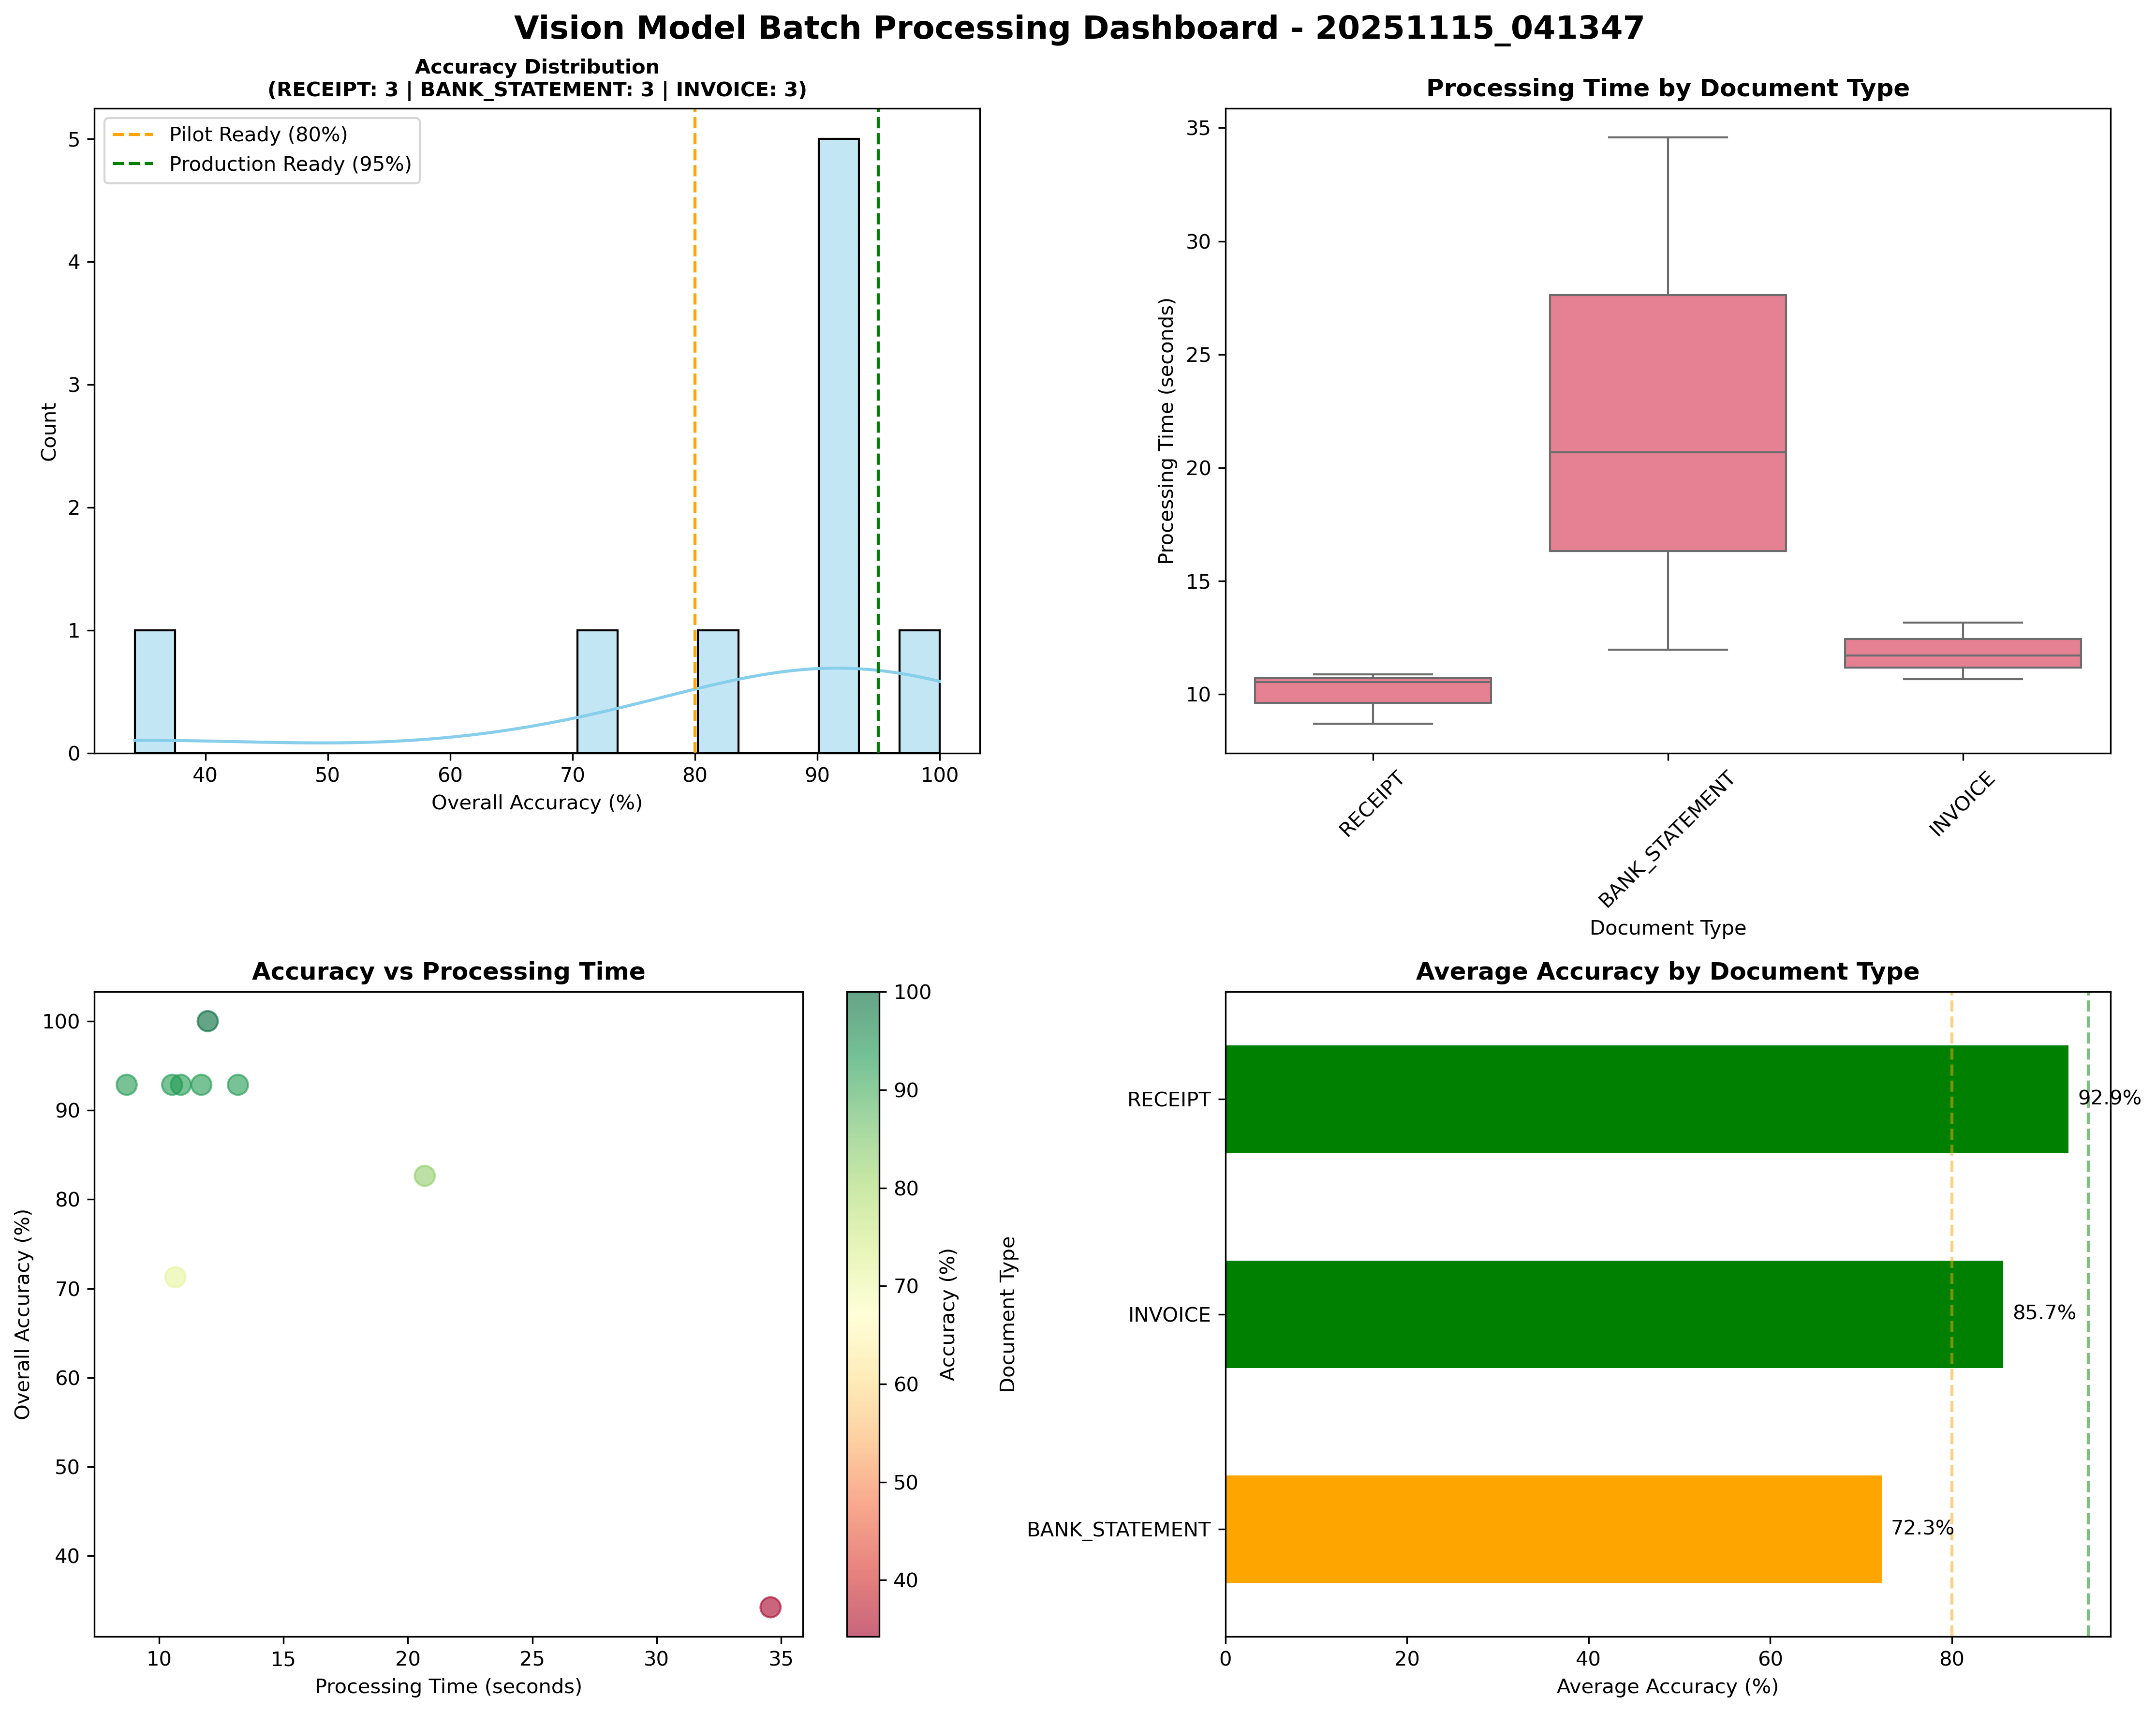

In [12]:
#Cell 12
# Display final summary
console.rule("[bold green]InternVL3.5-8B Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Overall Average Accuracy (across all images): {avg_accuracy:.2f}%[/cyan]")

# Show per-document-type breakdown
if len(df_results) > 0 and 'document_type' in df_results.columns:
    rprint("\n[bold blue]📊 Breakdown by Document Type:[/bold blue]")
    doc_type_stats = df_results.groupby('document_type').agg({
        'overall_accuracy': 'mean',
        'image_name': 'count'
    }).sort_values('overall_accuracy', ascending=False)
    
    for doc_type, row in doc_type_stats.iterrows():
        count = int(row['image_name'])
        acc = row['overall_accuracy']
        rprint(f"[cyan]  {doc_type.upper()}: {acc:.1f}% (n={count} images)[/cyan]")

rprint(f"\n[cyan]Output: {OUTPUT_BASE}[/cyan]")
rprint("[blue]🚀 Model: InternVL3.5-8B with Cascade RL and ViR[/blue]")

# Performance assessment
if successful == total_images and avg_accuracy > 50:
    rprint("\n[bold green]🎉 SUCCESS: InternVL3.5-8B processing completed successfully![/bold green]")
    rprint("[green]✅ Enhanced reasoning with Cascade RL is working[/green]")
    rprint("[green]✅ Dynamic resolution adjustment with ViR is active[/green]")
elif successful < total_images:
    rprint("\n[bold red]❌ FAILURE: Processing errors occurred[/bold red]")
    rprint("[red]🔍 Review error logs for diagnostic information[/red]")
elif avg_accuracy < 30:
    rprint("\n[bold yellow]⚠️ POOR PERFORMANCE: Low accuracy detected[/bold yellow]")
    rprint("[yellow]🔍 Review extraction results for quality issues[/yellow]")
else:
    rprint("\n[bold blue]📊 MIXED RESULTS: Partially working[/bold blue]")
    rprint("[blue]🔍 Review individual results to assess performance[/blue]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]📋 Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

## 13. Failed Extractions

In [13]:
#Cell 13
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 9

Documents with 0% accuracy: 0

✅ No documents with 0% accuracy - all extractions had some success!